#Data Description
# bank client data:

age: Age of the client

job: Type of job

marital: Marital status of the client

education: Highest education of the client

default: Has credit in default?

balance: The amount in the client’s bank account in the bank

housing: Whether the client has housing loan or not

loan: Whether the client has any personal loan or not

 

# related to the last contact of the current campaign:

contact: Contact communication type

month: Last contact month of the year

day_of_week: Last contact day of the week

duration: Last contact duration in seconds. Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

 

# other attributes:

campaign: number of contacts performed during this campaign and for this client

pdays: number of days that passed by after the client was last contacted from a previous campaign

previous: number of contacts performed before this campaign and for this client

poutcome: outcome of the previous marketing campaign

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/bank_marketing_data/training_set_label.csv" )
test_df = pd.read_csv("https://raw.githubusercontent.com/dphi-official/Datasets/master/bank_marketing_data/testing_set_label.csv" )

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribe
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


In [4]:
df.tail()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribe
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,1
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,1
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,1
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,0
45210,37,entrepreneur,married,secondary,no,2971,no,no,cellular,17,nov,361,2,188,11,other,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  subscribe  45211 non-null  int64 
dtypes: int64(8), object(9)
memory usage: 5.9+ MB


No missing values

In [6]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous,subscribe
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323,0.116985
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441,0.321406
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


### Visualize Data

See unique values

In [7]:
for col in df.columns:
    print(col)
    print(df[col].value_counts())
    print(100*'-')

age
32    2085
31    1996
33    1972
34    1930
35    1894
      ... 
90       2
92       2
93       2
95       2
94       1
Name: age, Length: 77, dtype: int64
----------------------------------------------------------------------------------------------------
job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64
----------------------------------------------------------------------------------------------------
marital
married     27214
single      12790
divorced     5207
Name: marital, dtype: int64
----------------------------------------------------------------------------------------------------
education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: education, dtype: int64
--------------------------------------

### Data Preparation

Label Encode

In [8]:
categorical = list(df.select_dtypes(include=['object']).columns.values)
categorical

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [9]:
cat_col_obj_uniques = {}
for cat in categorical:
    unique_val = df[cat].unique()
    obj_unique = {}
    for i in range(len(unique_val)):
        obj_unique[unique_val[i]] = i
    cat_col_obj_uniques[cat] = obj_unique
    df[cat] = pd.Series(df[cat].values.flatten()).map(obj_unique)

In [10]:
for cat in categorical:
    if cat != 'subscribe':
        test_df[cat] = pd.Series(test_df[cat].values.flatten()).map(cat_col_obj_uniques[cat])

Train / Validation Split

In [11]:
X = df.drop(['subscribe'], axis=1).values
y = df['subscribe'].values

In [12]:
X_test_pred = test_df.values

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

Scale data

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_test_pred = scaler.transform(X_test_pred)

### Model train

In [17]:
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier, plot_tree, plot_importance

In [18]:
dt = DecisionTreeClassifier()
# svc = SVC(probability=True)
ada_dt = AdaBoostClassifier(base_estimator=dt)
# ada_svc = AdaBoostClassifier(base_estimator=svc, n_estimators=10, random_state=0, learning_rate=0.3)
gbm = GradientBoostingClassifier()
xgb = XGBClassifier()
rf = RandomForestClassifier(criterion='entropy', max_leaf_nodes=20, oob_score=True, n_jobs=-1)

In [19]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [20]:
ada_dt.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                       

In [21]:
gbm.fit(X_train, y_train)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [22]:
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [23]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=20, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=True, random_state=None, verbose=0,
                       warm_start=False)

### Model Evaluation

In [24]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV, KFold, StratifiedKFold, cross_val_score
from sklearn.feature_selection import SelectFromModel

In [25]:
y_pred_dt = dt.predict(X_test)
# y_pred_svc = svc.predict(X_test)
y_pred_ada_dt = ada_dt.predict(X_test)
# y_pred_ada_svc = ada_svc.predict(X_test)
y_pred_gbm = gbm.predict(X_test)
y_pred_xgb = xgb.predict(X_test)
y_pred_rf = rf.predict(X_test)

In [26]:
def plot_confusion_matrix(y_test, y_pred, title):
    plt.figure(figsize=(16, 8))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, linewidths=0.5)
    plt.title(title)
    plt.show()

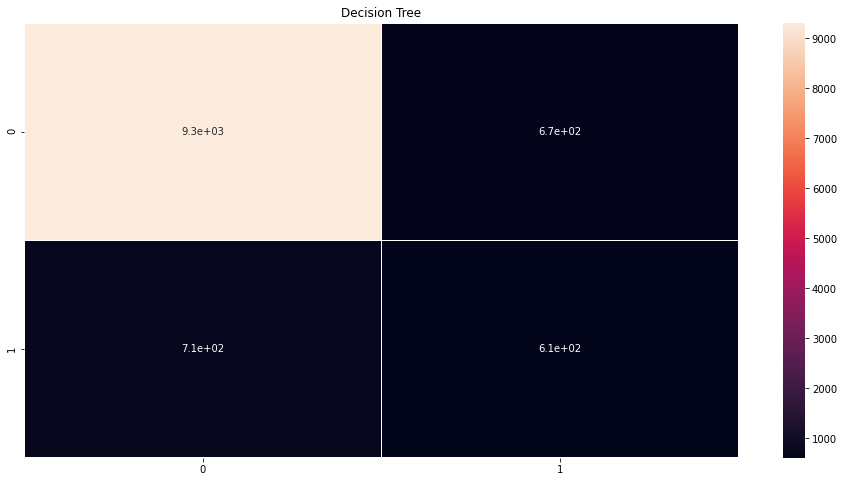

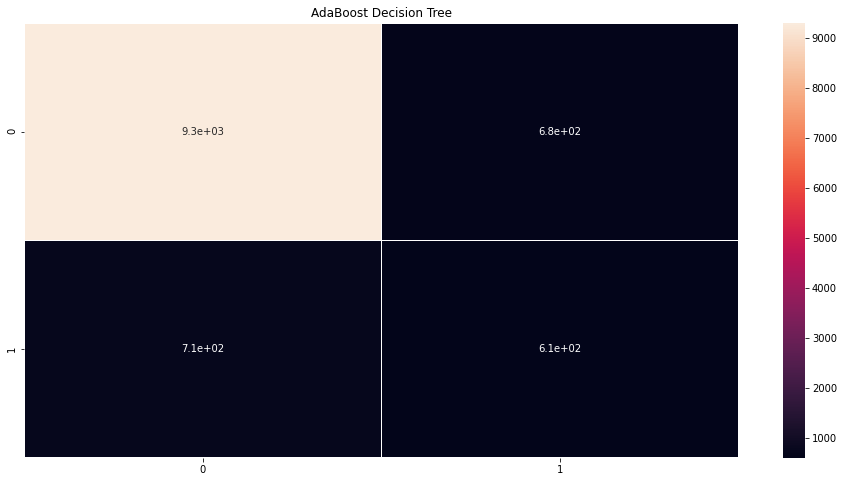

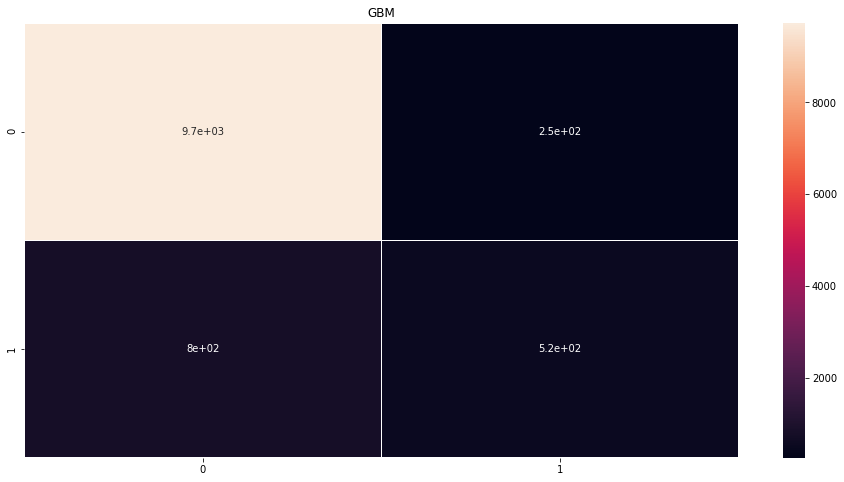

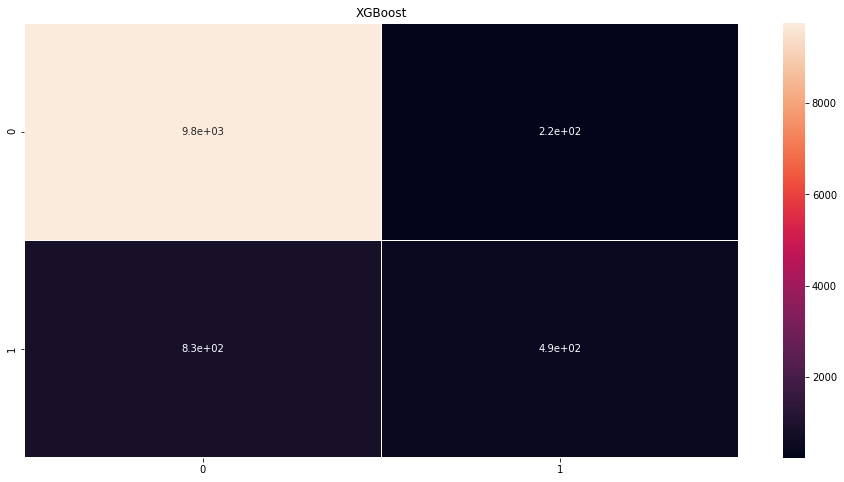

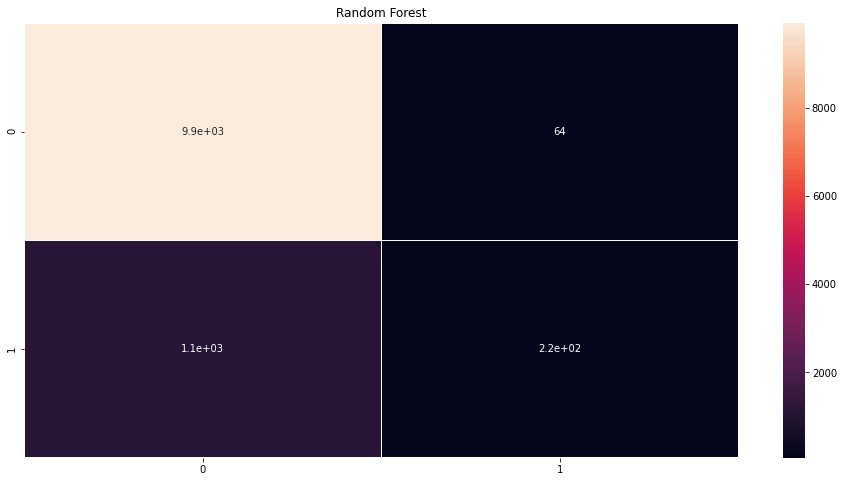

In [27]:
plot_confusion_matrix(y_test, y_pred_dt, 'Decision Tree')
# plot_confusion_matrix(y_test, y_pred_svc, 'SVC')
plot_confusion_matrix(y_test, y_pred_ada_dt, 'AdaBoost Decision Tree')
# plot_confusion_matrix(y_test, y_pred_ada_svc, 'AdaBoost SVC')
plot_confusion_matrix(y_test, y_pred_gbm, 'GBM')
plot_confusion_matrix(y_test, y_pred_xgb, 'XGBoost')
plot_confusion_matrix(y_test, y_pred_rf, 'Random Forest')

In [28]:
def print_classification_report(y_test, y_pred, title):
    print(title)
    print(classification_report(y_test, y_pred))
    print(100*'-')

In [29]:
print_classification_report(y_test, y_pred_dt, 'Decision Tree')
# print_classification_report(y_test, y_pred_svc, 'SVC')
print_classification_report(y_test, y_pred_ada_dt, 'AdaBoost Decision Tree')
# print_classification_report(y_test, y_pred_ada_svc, 'AdaBoost SVC')
print_classification_report(y_test, y_pred_gbm, 'GBM')
print_classification_report(y_test, y_pred_xgb, 'XGBoost')
print_classification_report(y_test, y_pred_rf, 'Random Forest')

Decision Tree
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      9981
           1       0.48      0.46      0.47      1322

    accuracy                           0.88     11303
   macro avg       0.70      0.70      0.70     11303
weighted avg       0.88      0.88      0.88     11303

----------------------------------------------------------------------------------------------------
AdaBoost Decision Tree
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      9981
           1       0.47      0.46      0.47      1322

    accuracy                           0.88     11303
   macro avg       0.70      0.70      0.70     11303
weighted avg       0.88      0.88      0.88     11303

----------------------------------------------------------------------------------------------------
GBM
              precision    recall  f1-score   support

           0       0.92      0.97      0.95     

In [30]:
acc = [dt.score(X_test, y_test),
       ada_dt.score(X_test, y_test),
       gbm.score(X_test, y_test),
       xgb.score(X_test, y_test),
       rf.score(X_test, y_test)
]
label = ['DT', 'AdaDT', 'GBM', 'XGB', 'RF']
idx = np.arange(len(label))

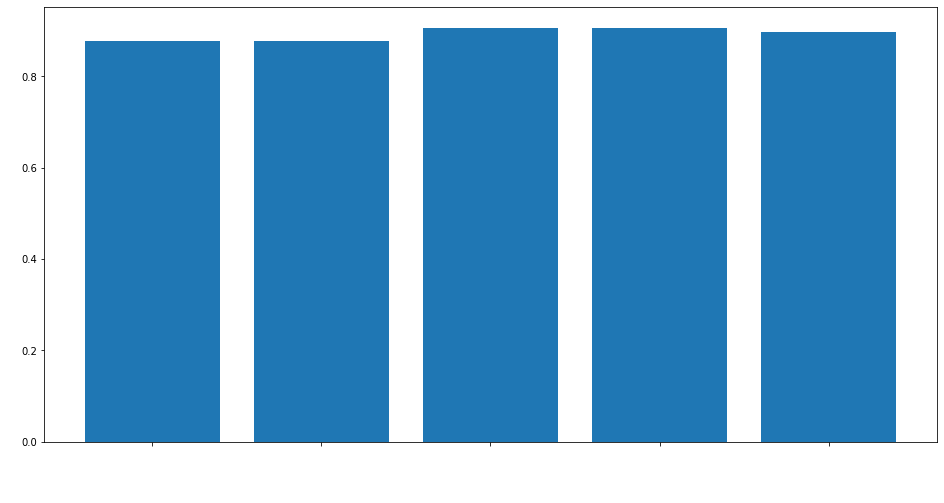

In [31]:
plt.figure(figsize=(16, 8))
plt.bar(idx, acc)
plt.xticks(idx, label, rotation=90, c='w')
plt.xlabel('Model', c='w')
plt.ylabel('Accuracy', c='w')
plt.show()

### Make Predictions

In [32]:
pred = gbm.predict(X_test_pred)
pred

array([0, 0, 0, ..., 0, 0, 0])

In [34]:
df_pred = pd.DataFrame({
    'prediction': pred
})

from google.colab import files
df_pred.to_csv('bm_pred.csv', index=False)
files.download('bm_pred.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>